In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cvxpy as cp
from sklearn.linear_model import LinearRegression

In [2]:
raw_data = pd.read_excel('Data.xlsx', sheet_name=None, index_col=0)

In [3]:
data = {}
sheet_names = list(raw_data.keys())

for s in sheet_names:
    if s == 'FamaFrenchFactors':
        new_name = s
        col_labels = raw_data[s].columns
    else:
        new_name = s[18:]
        col_labels = range(1, 11)
    
    data[new_name] = raw_data.pop(s)
    data[new_name].columns = col_labels
    data[new_name].index = (pd.to_datetime(data[new_name].index, format='%Y%m')
                            .to_period('M').rename('Date'))

## Question 3

In [4]:
class Portfolio:
    def __init__(
        self, mu: pd.Series, S: pd.DataFrame,
        long_only: bool = False,
        ret: float = None, sd: float = None, sharpe: float = None,
        weights: np.ndarray = None
    ) -> None:
        self.mu = mu
        self.S = S
        self.long_only = long_only
        self.ret = ret
        self.sd = sd
        self.sharpe = sharpe
        self.weights = weights

    def optimize_weights(self, target_ret: float = None) -> None:
        w = cp.Variable(self.mu.size)
        ret = self.mu.values @ w
        var = cp.quad_form(w, self.S.values)

        if target_ret is not None:
            self.ret = target_ret
        elif self.ret is None:
            print("Error: target return not specified")
            return

        if self.long_only:
            prob = cp.Problem(cp.Minimize(var),
                              [cp.sum(w) == 1, ret == self.ret, w >= 0])
        else:
            prob = cp.Problem(cp.Minimize(var),
                              [cp.sum(w) == 1, ret == self.ret])
        
        var_opt = prob.solve()

        self.ret = float(self.ret)
        self.sd = np.sqrt(var_opt)
        self.weights = np.array(w.value)

    
    def get_sharpe(self, risk_free_rate: float) -> float:
        self.sharpe = (self.ret - risk_free_rate) / self.sd
        return self.sharpe

In [5]:
class P_Efficient_Frontier:
    def __init__(
        self,
        ret_range: np.ndarray,
        portfolios: list[Portfolio] = []
) -> None:
        self.ret_range = list(ret_range)
        self.portfolios = portfolios


    def generate_ef(self, mu: pd.Series, S: pd.DataFrame, long_only: bool = False):
        self.portfolios = []
        for r in self.ret_range:
            p = Portfolio(mu, S, long_only=long_only)
            p.optimize_weights(target_ret=r)
            self.portfolios.append(p)


    def get_tan_p(self, risk_free_rate: float) -> Portfolio:
        list_sharpe = []
        for i in range(len(self.ret_range)):
            list_sharpe.append(self.portfolios[i].get_sharpe(risk_free_rate))
        
        idx_max_sharpe = np.argmax(np.array(list_sharpe))
        return self.portfolios[idx_max_sharpe]


    def get_sd_ret_arr(self):
        sd_arr = []
        ret_arr = []
        for p in self.portfolios:
            sd_arr.append(p.sd)
            ret_arr.append(p.ret)
        
        return (sd_arr, ret_arr)

In [6]:
rf_mu = data['FamaFrenchFactors']['RF'].mean()
rf_mu

0.36216366158113733

In [7]:
p_inv_mu = data['Investment'].mean()
p_inv_ex = data['Investment'] - p_inv_mu
p_inv_S = p_inv_ex.cov()

In [8]:
ef_inv = P_Efficient_Frontier(ret_range=np.linspace(0, 2, 200))
ef_inv.generate_ef(p_inv_mu, p_inv_S)
tanp_inv = ef_inv.get_tan_p(risk_free_rate=rf_mu)

In [9]:
tanp_inv.ret, tanp_inv.sd, tanp_inv.sharpe

(1.6080402010050252, 5.147896588073307, 0.2420166213731538)

In [10]:
tanp_inv.weights

array([ 0.40781556,  0.79465305,  0.52837744, -0.20908625, -0.11511586,
       -0.31282123,  0.3852204 ,  0.31157557,  0.86795987, -1.65857855])

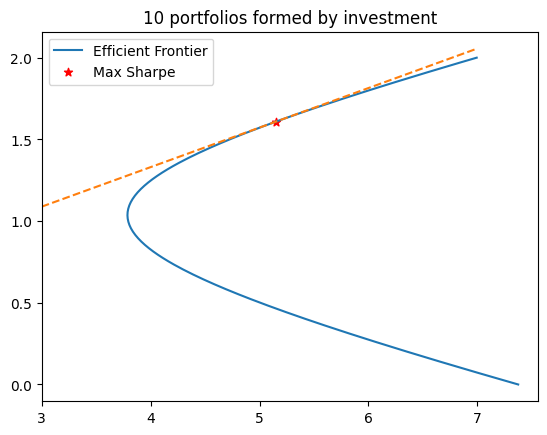

In [11]:
_, ax = plt.subplots()

sd_ef_inv, ret_ef_inv = ef_inv.get_sd_ret_arr()

ax.plot(sd_ef_inv, ret_ef_inv, label='Efficient Frontier')

ax.scatter(tanp_inv.sd, tanp_inv.ret, marker="*", c="r", label="Max Sharpe")

ax.set_xlim(3, )
ax.plot([3, 7],
        [3 * tanp_inv.sharpe + rf_mu, 7 * tanp_inv.sharpe + rf_mu],
        '--')

ax.set_title("10 portfolios formed by investment")
ax.legend()
plt.show()

In [12]:
p_20 = pd.concat([data['Investment'], data['Profitability']], axis=1)
p_20.columns = ([f'inv_{i}' for i in data['Investment'].columns]
                + [f'prof_{i}' for i in data['Profitability'].columns])

In [13]:
p_20_mu = p_20.mean()
p_20_S = (p_20 - p_20_mu).cov()

In [14]:
ef_20 = P_Efficient_Frontier(ret_range=np.linspace(0, 4, 400))
ef_20.generate_ef(p_20_mu, p_20_S)
tanp_20 = ef_20.get_tan_p(risk_free_rate=rf_mu)

In [15]:
tanp_20.ret, tanp_20.sd, tanp_20.sharpe

(2.0350877192982457, 5.593824346035855, 0.2990662477456323)

In [16]:
tanp_20.weights

array([ 0.78988051,  0.99014918,  0.56167952,  0.58888532,  0.17093563,
       -0.25742778,  0.28170231,  0.31519619,  0.78938115, -0.95186396,
       -0.37081168, -0.60565736, -0.78919639, -0.54669002,  0.44796668,
       -0.75018478, -0.22358038,  0.06362291,  0.63441061, -0.13839766])

In [17]:
p_30 = pd.concat([data['Investment'], data['Profitability'], data['Momentum']],
                 axis=1)
p_30.columns = ([f'inv_{i}' for i in data['Investment'].columns]
                + [f'prof_{i}' for i in data['Profitability'].columns]
                + [f'mom_{i}' for i in data['Momentum'].columns])

In [18]:
p_30_mu = p_30.mean()
p_30_S = (p_30 - p_30_mu).cov()

In [19]:
ef_30 = P_Efficient_Frontier(ret_range=np.linspace(0, 4, 400))
ef_30.generate_ef(p_30_mu, p_30_S)
tanp_30 = ef_30.get_tan_p(risk_free_rate=rf_mu)

In [20]:
tanp_30.ret, tanp_30.sd, tanp_30.sharpe

(3.2180451127819545, 7.250488713684098, 0.3938881314042753)

In [21]:
tanp_30.weights

array([ 0.47510953,  0.78206432,  0.63087101,  0.36542712, -0.0805739 ,
       -0.36666614, -0.02724849, -0.11491686,  0.29314728, -1.49698766,
       -0.5103277 , -0.55616111, -0.64796704, -0.55649414,  0.67394582,
       -0.79013437,  0.19087547,  0.39121704,  0.45853068,  0.09833374,
       -0.63605413,  0.43168549,  0.9173083 ,  0.78970808, -0.45781271,
       -0.04901819, -0.52625056, -0.03100014, -0.46699115,  1.81638042])

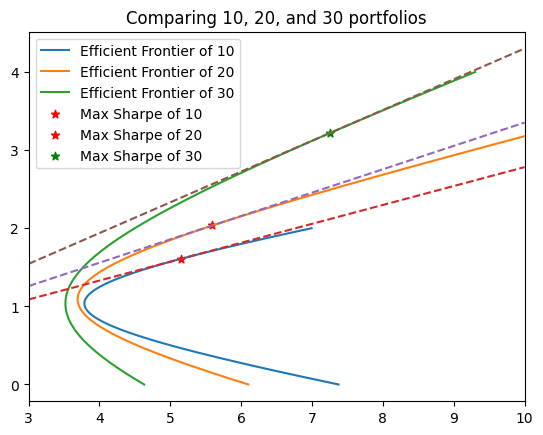

In [22]:
_, ax = plt.subplots()

ax.plot(sd_ef_inv, ret_ef_inv, label='Efficient Frontier of 10')

sd_ef_20, ret_ef_20 = ef_20.get_sd_ret_arr()
ax.plot(sd_ef_20, ret_ef_20, label='Efficient Frontier of 20')

sd_ef_30, ret_ef_30 = ef_30.get_sd_ret_arr()
ax.plot(sd_ef_30, ret_ef_30, label='Efficient Frontier of 30')

ax.scatter(tanp_inv.sd, tanp_inv.ret, marker="*", c="r", label="Max Sharpe of 10")
ax.scatter(tanp_20.sd, tanp_20.ret, marker="*", c="r", label="Max Sharpe of 20")
ax.scatter(tanp_30.sd, tanp_30.ret, marker="*", c="g", label="Max Sharpe of 30")

ax.set_xlim(3, )
ax.plot([3, 10],
        [3 * tanp_inv.sharpe + rf_mu, 10 * tanp_inv.sharpe + rf_mu],
        '--')
ax.set_xlim(3, 10)
ax.plot([3, 10],
        [3 * tanp_20.sharpe + rf_mu, 10 * tanp_20.sharpe + rf_mu],
        '--')
ax.plot([3, 10],
        [3 * tanp_30.sharpe + rf_mu, 10 * tanp_30.sharpe + rf_mu],
        '--')

ax.set_title("Comparing 10, 20, and 30 portfolios")

ax.legend()
plt.show()

In [23]:
df_tanp_30 = pd.DataFrame({
    'mean_return': p_30_mu,
    'sd_return': np.sqrt(np.diag(p_30_S))
})

df_tanp_30['sharpe'] = (df_tanp_30['mean_return'] - rf_mu) / df_tanp_30['sd_return']
df_tanp_30['weights'] = tanp_30.weights

df_tanp_30 = df_tanp_30.sort_values(by='weights', ascending=False)
df_tanp_30

,mean_return,sd_return,sharpe,weights
mom_10,1.475284,6.118831,0.181917,1.816380
mom_3,0.913426,5.449894,0.101151,0.917308
mom_4,0.942635,4.899604,0.118473,0.789708
inv_2,1.151318,4.750456,0.166122,0.782064
prof_5,0.997906,4.675570,0.135971,0.673946
inv_3,1.067323,4.356696,0.161857,0.630871
inv_1,1.163939,5.358714,0.149621,0.475110
prof_9,1.075284,4.547001,0.156833,0.458531
mom_2,0.774466,6.488377,0.063545,0.431685
prof_8,1.030042,4.526771,0.147540,0.391217


In [24]:
df_tanp_30.corr()

,mean_return,sd_return,sharpe,weights
mean_return,1.000000,-0.529972,0.928828,0.631035
sd_return,-0.529972,1.000000,-0.756718,-0.079825
sharpe,0.928828,-0.756718,1.000000,0.521095
weights,0.631035,-0.079825,0.521095,1.000000


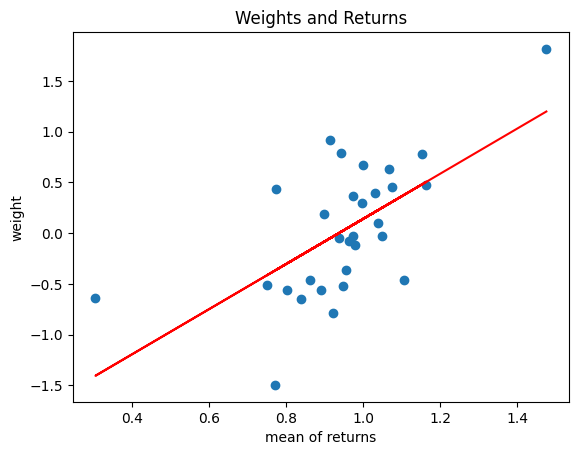

In [25]:
lm_ret = LinearRegression().fit(df_tanp_30['mean_return'].values.reshape(-1, 1),
                                df_tanp_30['weights'].values)
w_pred_ret = lm_ret.predict(df_tanp_30['mean_return'].values.reshape(-1, 1))

plt.scatter(df_tanp_30['mean_return'], df_tanp_30['weights'])
plt.plot(df_tanp_30['mean_return'], w_pred_ret, c="r")
plt.title("Weights and Returns")
plt.xlabel("mean of returns")
plt.ylabel("weight")
plt.show()

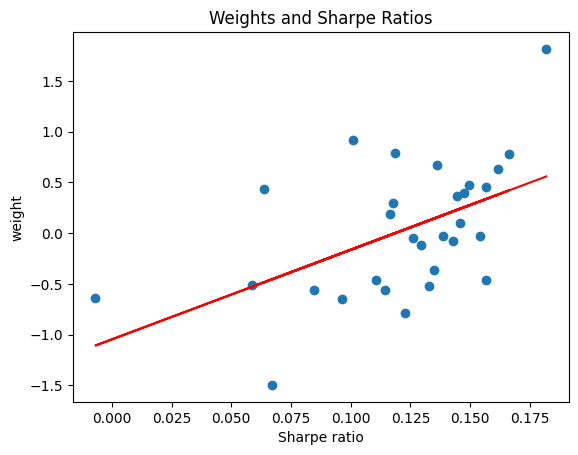

In [26]:
lm_sharpe = LinearRegression().fit(df_tanp_30['sharpe'].values.reshape(-1, 1),
                                df_tanp_30['weights'].values)
w_pred_sharpe = lm_sharpe.predict(df_tanp_30['sharpe'].values.reshape(-1, 1))

plt.scatter(df_tanp_30['sharpe'], df_tanp_30['weights'])
plt.plot(df_tanp_30['sharpe'], w_pred_sharpe, c="r")
plt.title("Weights and Sharpe Ratios")
plt.xlabel("Sharpe ratio")
plt.ylabel("weight")
plt.show()

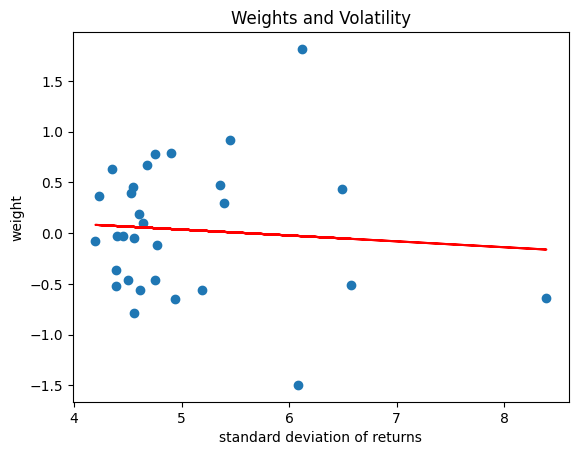

In [27]:
lm_sd = LinearRegression().fit(df_tanp_30['sd_return'].values.reshape(-1, 1),
                                df_tanp_30['weights'].values)
w_pred_sd = lm_sd.predict(df_tanp_30['sd_return'].values.reshape(-1, 1))

plt.scatter(df_tanp_30['sd_return'], df_tanp_30['weights'])
plt.plot(df_tanp_30['sd_return'], w_pred_sd, c="r")
plt.title("Weights and Volatility")
plt.xlabel("standard deviation of returns")
plt.ylabel("weight")
plt.show()

In [28]:
ef_30_long = P_Efficient_Frontier(ret_range=np.linspace(0, 2, 200))
ef_30_long.generate_ef(p_30_mu, p_30_S, long_only=True)
tanp_30_long = ef_30_long.get_tan_p(risk_free_rate=rf_mu)

In [29]:
tanp_30_long.ret, tanp_30_long.sd, tanp_30_long.sharpe

(1.3165829145728642, 5.065741491751002, 0.18840662409360856)

In [30]:
tanp_30_long.weights.round(decimals=8)

array([-0.        ,  0.25682331,  0.18506469, -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.55811199])

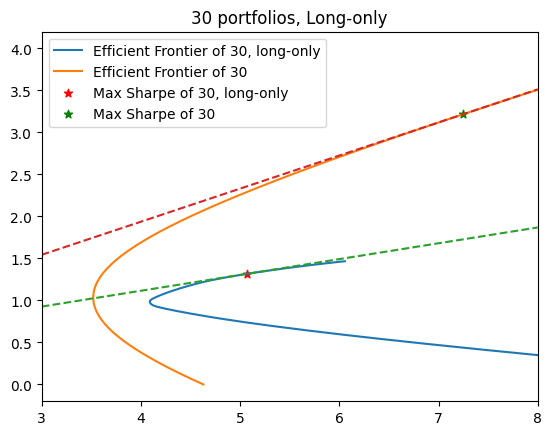

In [31]:
_, ax = plt.subplots()

sd_ef_30_long, ret_ef_30_long = ef_30_long.get_sd_ret_arr()
ax.plot(sd_ef_30_long, ret_ef_30_long,
        label='Efficient Frontier of 30, long-only')

sd_ef_30, ret_ef_30 = ef_30.get_sd_ret_arr()
ax.plot(sd_ef_30, ret_ef_30,
        label='Efficient Frontier of 30')

ax.scatter(tanp_30_long.sd, tanp_30_long.ret, marker="*", c="r",
           label="Max Sharpe of 30, long-only")
ax.scatter(tanp_30.sd, tanp_30.ret, marker="*", c="g",
           label="Max Sharpe of 30")

ax.set_xlim(3, 8)
ax.plot([3, 8],
        [3 * tanp_30_long.sharpe + rf_mu, 8 * tanp_30_long.sharpe + rf_mu],
        '--')
ax.plot([3, 8],
        [3 * tanp_30.sharpe + rf_mu, 8 * tanp_30.sharpe + rf_mu],
        '--')

ax.set_title("30 portfolios, Long-only")

ax.legend()
plt.show()

In [32]:
df_tanp_30_long = pd.DataFrame({
    'mean_return': p_30_mu,
    'sd_return': np.sqrt(np.diag(p_30_S))
})

df_tanp_30_long['sharpe'] = (df_tanp_30_long['mean_return'] - rf_mu) / df_tanp_30_long['sd_return']
df_tanp_30_long['weights'] = tanp_30_long.weights.round(decimals=8)

df_tanp_30_long = df_tanp_30_long.sort_values(by='sharpe', ascending=False)
df_tanp_30_long

,mean_return,sd_return,sharpe,weights
mom_10,1.475284,6.118831,0.181917,0.558112
inv_2,1.151318,4.750456,0.166122,0.256823
inv_3,1.067323,4.356696,0.161857,0.185065
prof_9,1.075284,4.547001,0.156833,-0.000000
mom_9,1.106463,4.756176,0.156491,-0.000000
mom_8,1.049528,4.456146,0.154251,-0.000000
inv_1,1.163939,5.358714,0.149621,-0.000000
prof_8,1.030042,4.526771,0.147540,-0.000000
prof_10,1.038655,4.644635,0.145650,-0.000000
inv_4,0.973245,4.230571,0.144444,-0.000000
